IMPORT LIBRARIES AND LOAD DATASETS

In [1]:
import os
for dirname, _, filenames in os.walk("G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\2021.wanlp-1.51.pdf
G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\C14-1022.pdf
G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\Context-Based_Feature_Technique_for_Sarcasm_Identification_in_Benchmark_Datasets_Using_Deep_Learning_and_BERT_Model.pdf
G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\corpus.pkl
G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\dictionary.gensim
G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\LSTM, CN

In [2]:
#!python -m spacy download en
#spacy.load('en_core_web_sm')
import spacy

from spacy.cli import download

print(download('en_core_web_sm'))

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
None


In [3]:
import tensorflow as tf
import pandas as pd
import json
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
#from spacy import en_core_web_sm   
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, PrecisionRecallDisplay
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
#import spacy
from nltk.corpus import stopwords
tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

print(tf.__version__)  # 2.0.0-beta0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\711994\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2.12.0


In [4]:
sarcasm_data1 = pd.read_json("G:\\SECOND SEMESTER\\I CAN PLUS TO GOD BE ALL GLORY\\APPLIED ARTFICIAL INTELLIGENCE\\GRADED FOLDER\\SARCASM DETECTION IN SENTIMENT ANALYSIS\\Sarcasm_Headlines_Dataset.json\\Sarcasm_Headlines_Dataset.json", lines=True)
sarcasm_data2 = pd.read_json("G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\Sarcasm_Headlines_Dataset_v2.json\Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [5]:
data1 = sarcasm_data1[['headline','is_sarcastic']]
data2 = sarcasm_data2[['headline','is_sarcastic']]

sarcasm_main = pd.concat([data1,data2])
sarcasm_main.reset_index(drop=True, inplace=True)

In [6]:
sarcasm_main

headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
...                                                  ...           ...
55323       jews to celebrate rosh hashasha or something             1
55324  internal affairs investigator disappointed con...             1
55325  the most beautiful acceptance speech this week...             0
55326  mars probe destroyed by orbiting spielberg-gat...             1
55327                 dad clarifies this not a food stop             1

[55328 rows x 2 columns]

### EDA and Text Preprocessing

In [7]:
sarcasm_main.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

### Finding the Classes Balance/Imbalance

In [8]:
px.bar(sarcasm_main.groupby('is_sarcastic').count().reset_index(), x='headline',title='Count of Sarcastic and Non Sarcastic Headlines')


In [9]:
Sarcasm_projection_target = sarcasm_main ['is_sarcastic'].value_counts()
labels = ['Non_Sarcastic', 'Sarcastic']
sizes = (np.array((Sarcasm_projection_target / Sarcasm_projection_target.sum())*100))
colors = ['#58D68D', '#9B59B6']

trace = go.Pie(labels=labels, values=sizes, opacity = 0.8, hoverinfo='label+percent',
               marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(
    title='Sarcastic Vs Non_Sarcastic'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="Sa_Proj")

In [10]:
sarcasm_main['headline_count'] = sarcasm_main.headline.apply(lambda x: len(list(x.split())))
sarcasm_main['headline_unique_word_count'] = sarcasm_main.headline.apply(lambda x: len(set(x.split())))
sarcasm_main['headline_has_digits'] = sarcasm_main.headline.apply(lambda x: bool(re.search(r'\d', x)))
sarcasm_main

headline  is_sarcastic  \
0      former versace store clerk sues over secret 'b...             0   
1      the 'roseanne' revival catches up to our thorn...             0   
2      mom starting to fear son's web series closest ...             1   
3      boehner just wants wife to listen, not come up...             1   
4      j.k. rowling wishes snape happy birthday in th...             0   
...                                                  ...           ...   
55323       jews to celebrate rosh hashasha or something             1   
55324  internal affairs investigator disappointed con...             1   
55325  the most beautiful acceptance speech this week...             0   
55326  mars probe destroyed by orbiting spielberg-gat...             1   
55327                 dad clarifies this not a food stop             1   

       headline_count  headline_unique_word_count  headline_has_digits  
0                  12                          12                False  
1                  14                          14                False  
2                  14                          13                False  
3                  13                          13                False  
4                  11                          11                False  
...               ...                         ...                  ...  
55323               7                           7                False  
55324              13                          12                False  
55325              12                          12                False  
55326               8                           8                False  
55327               7                           7                False  

[55328 rows x 5 columns]

#### Frequent Occuring word (unclean) in Headlines

In [11]:
all_words = sarcasm_main['headline'].str.split(expand=True).unstack().value_counts()
sarcasm_unclean = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Frequent Occuring word (unclean) in Headlines'
)

fig = go.Figure(data=sarcasm_unclean, layout=layout)

iplot(fig, filename='basic-bar')

From the above plot its clearly evident that the headlines need to be cleaned as the top 50 most occuring words are joint words and indirect words which does not provide any meaning.

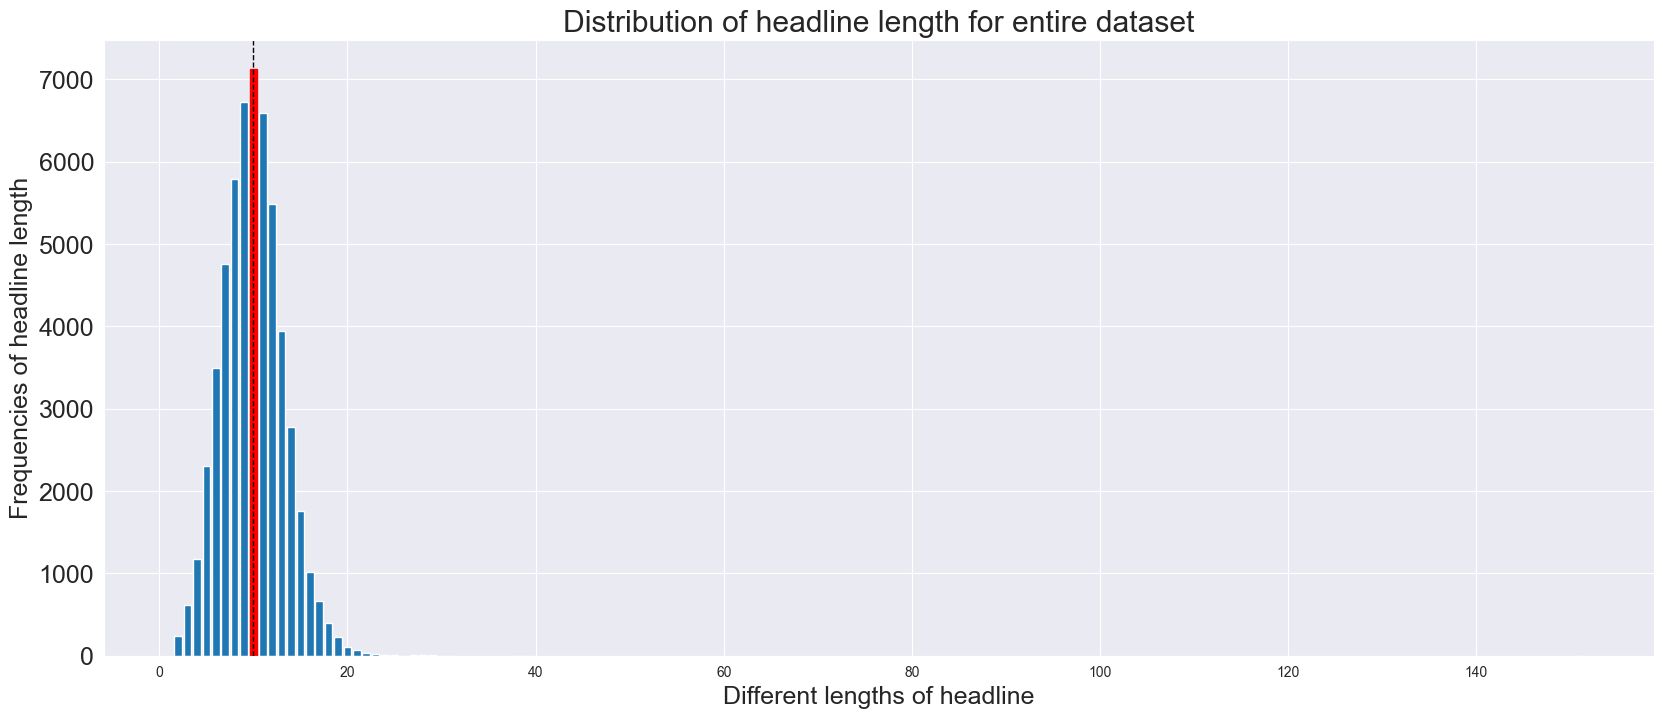

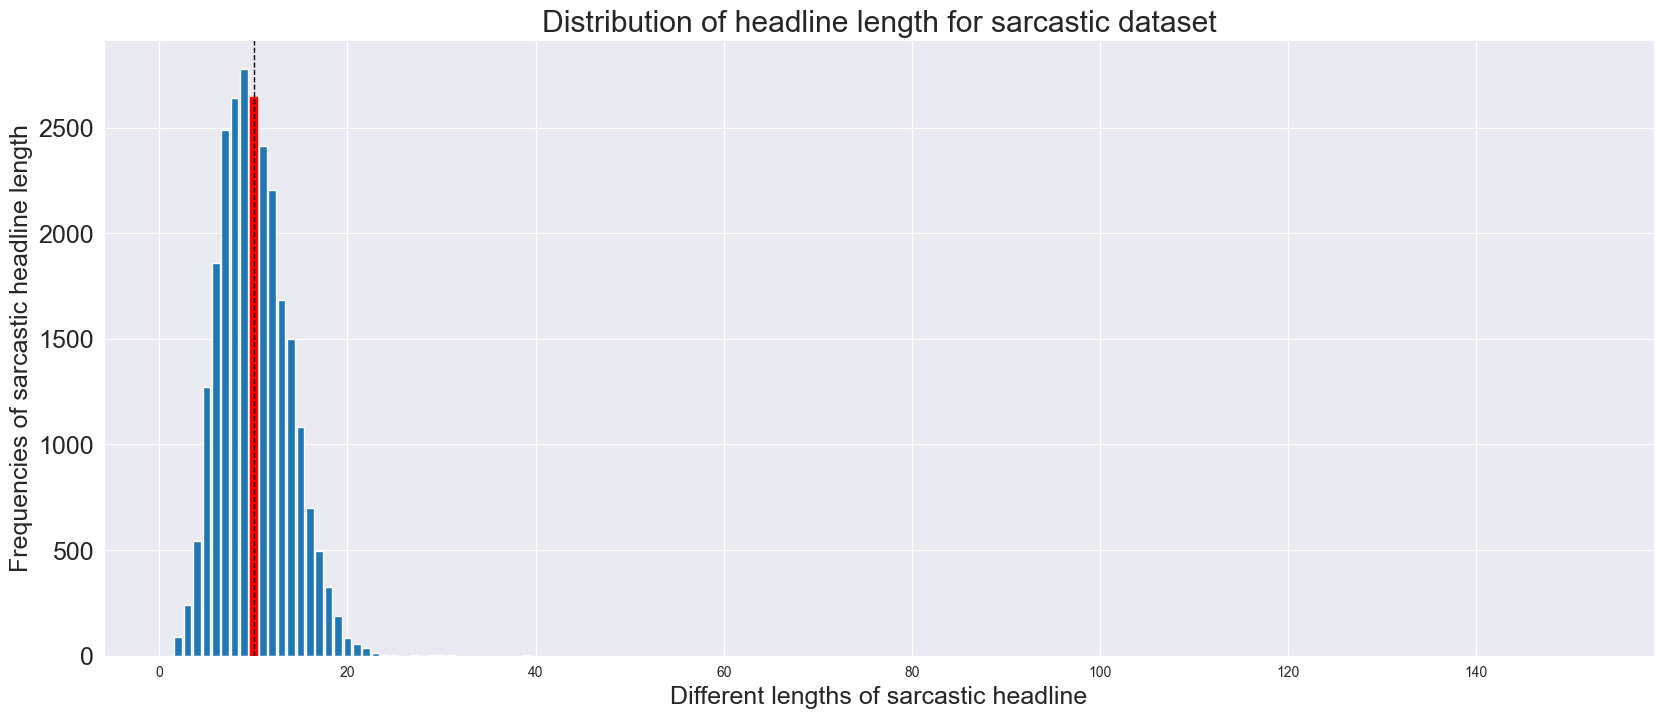

In [12]:
all_dat = sarcasm_main.groupby('headline_count').count()
sarcastic_dat1 = sarcasm_main [sarcasm_main.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
non_sarcastic_dat1 = sarcasm_main[sarcasm_main.is_sarcastic==0]
non_sarcastic_dat = non_sarcastic_dat1.groupby('headline_count').count()

plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(sarcasm_main.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

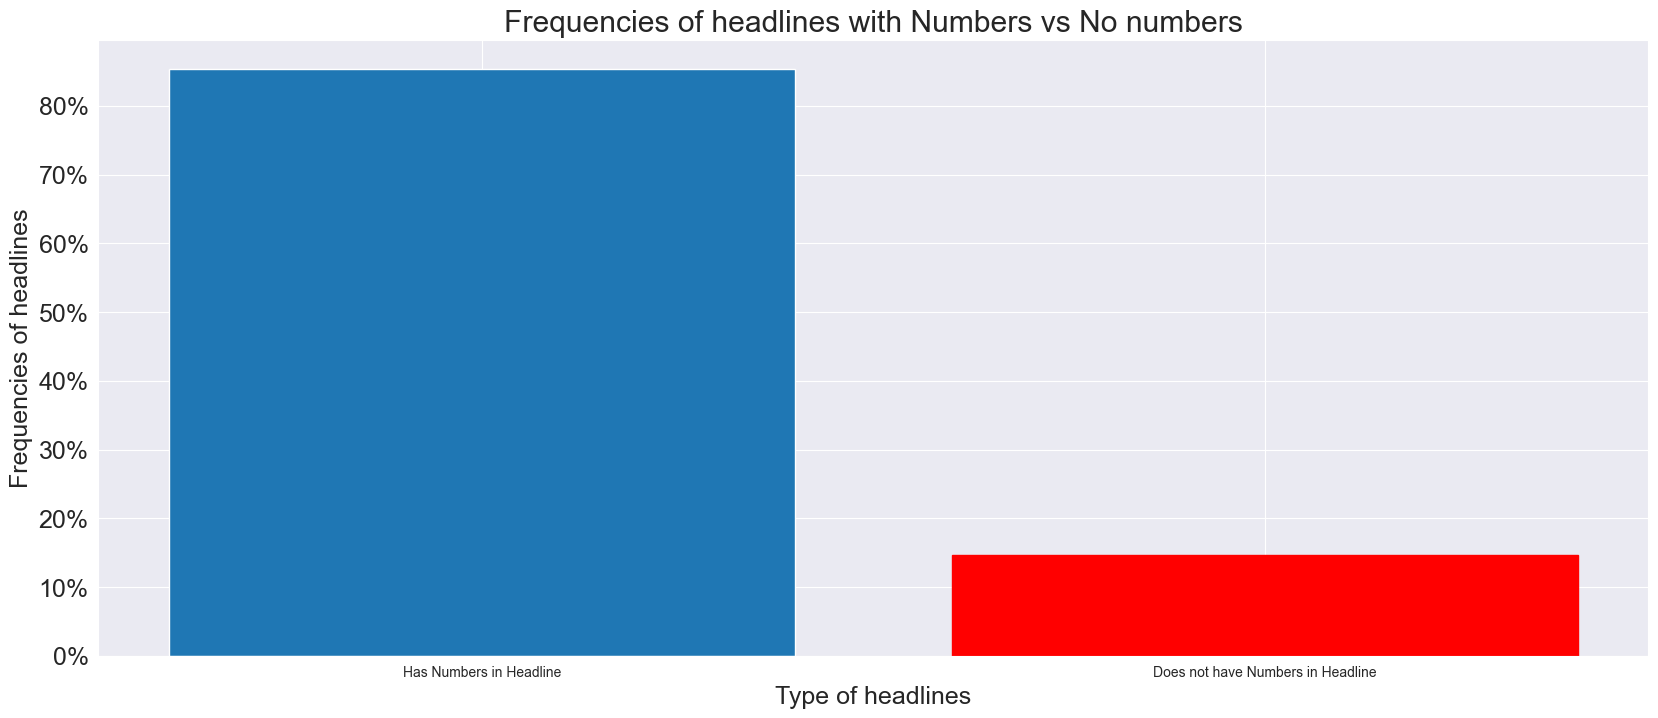

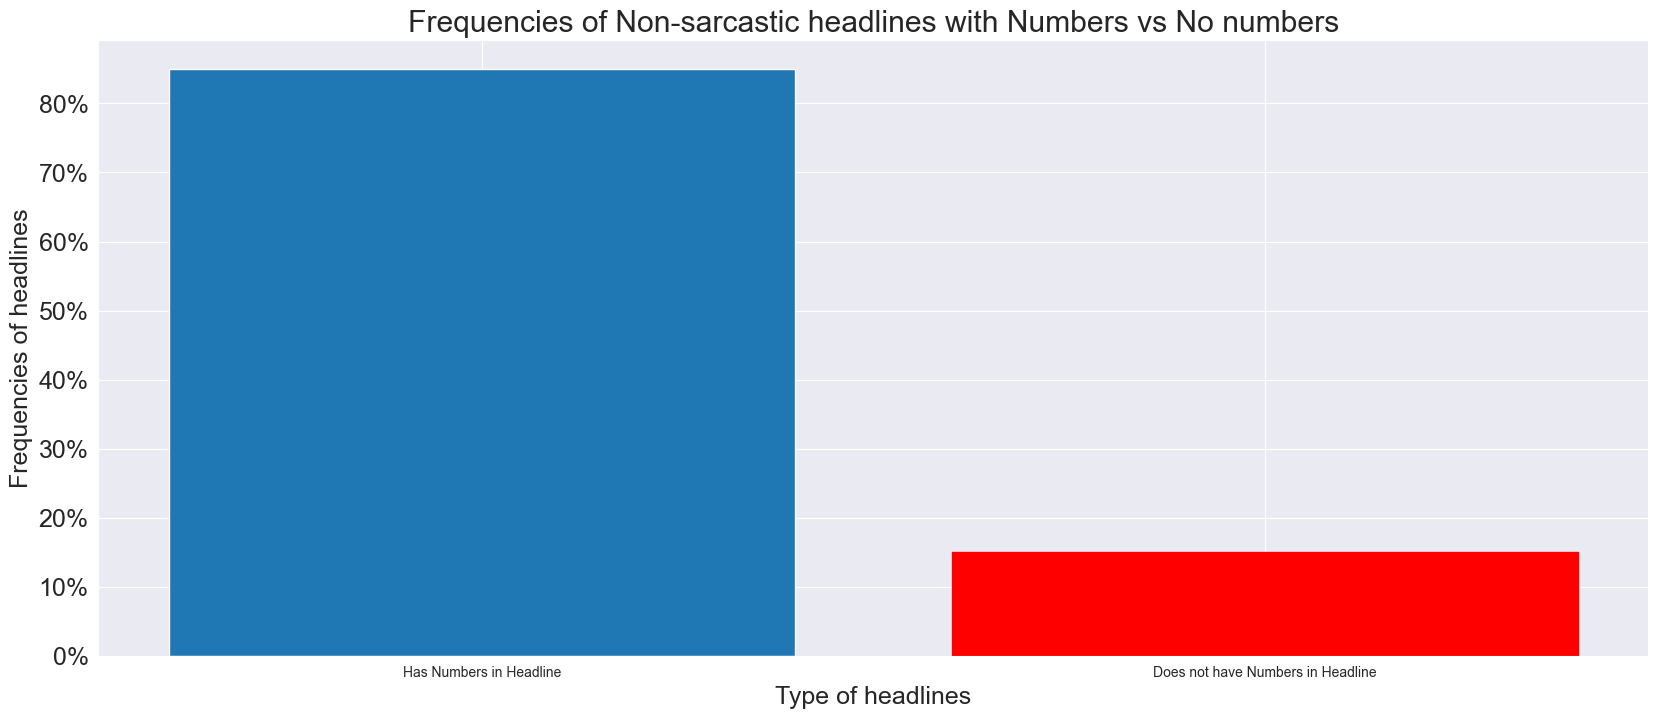

Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64
Has Numbers in Headline              0.86
Does not have Numbers in Headline    0.14
Name: headline, dtype: float64
Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64


In [13]:
digital_data = sarcasm_main.groupby('headline_has_digits').count()
digital_data.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of headlines with Numbers vs No numbers')
bar_graph = plt.bar(digital_data.index, digital_data.headline / digital_data.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

sarcastic_digital_data = sarcasm_main[sarcasm_main.is_sarcastic==1].groupby('headline_has_digits').count()
sarcastic_digital_data.index = ['Has Numbers in Headline','Does not have Numbers in Headline']



non_sarcastic_digital_data = sarcasm_main[sarcasm_main.is_sarcastic==0].groupby('headline_has_digits').count()
non_sarcastic_digital_data.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Non-sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(non_sarcastic_digital_data.index, non_sarcastic_digital_data.headline / non_sarcastic_digital_data.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(round(digital_data.headline / digital_data.headline_count.sum(),2))
print(round(sarcastic_digital_data.headline / sarcastic_digital_data.headline_count.sum(),2))
print(round(non_sarcastic_digital_data.headline / non_sarcastic_digital_data.headline_count.sum(),2))


In [14]:
sarcasm_detection = sarcasm_main[sarcasm_main.is_sarcastic==1]
sarcasm_detection.reset_index(drop=True, inplace=True)
non_sarcasm_detection = sarcasm_main[sarcasm_main.is_sarcastic==0]
non_sarcasm_detection.reset_index(drop=True, inplace=True)

# Tokenizing the Headlines of Sarcasm
sarcastic_reviews = []
for rows in range(0, sarcasm_detection.shape[0]):
    head_txt = sarcasm_detection.headline[rows]
    head_txt = head_txt.split(" ")
    sarcastic_reviews.append(head_txt)

#Converting into single list for Sarcasm
import itertools
sarcastic_list = list(itertools.chain(*sarcastic_reviews))

# Tokenizing the Headlines of Non-Sarcasm
non_sarcastic_reviews = []
for rows in range(0, non_sarcasm_detection.shape[0]):
    head_txt = non_sarcasm_detection.headline[rows]
    head_txt = head_txt.split(" ")
    non_sarcastic_reviews.append(head_txt)
    
#Converting into single list for Non-sarcastic
non_sarcastic_list = list(itertools.chain(*non_sarcastic_reviews))

#### REMOVING STOPWORDS

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
sarcastic_list_restp = [word for word in sarcastic_list if word.lower() not in stopwords]
non_sarcastic_list_restp = [word for word in non_sarcastic_list if word.lower() not in stopwords]

print("Length of original Sarcastic list: {0} words\n"
      "Length of Sarcastic list after stopwords removal: {1} words"
      .format(len(sarcastic_list), len(sarcastic_list_restp)))

print("=="*46)

print("Length of original Non Sarcastic list: {0} words\n"
      "Length of Non Sarcastic list after stopwords removal: {1} words"
      .format(len(non_sarcastic_list), len(non_sarcastic_list_restp)))

Length of original Sarcastic list: 256444 words
Length of Sarcastic list after stopwords removal: 193085 words
Length of original Non Sarcastic list: 294256 words
Length of Non Sarcastic list after stopwords removal: 207050 words


In [16]:
##### Top 30 Occuring words after removing Stopwords from Headlines - Sarcasm Vs Non Sarcastic

#Data cleaning for getting top 30
from collections import Counter
sarcasm_count = Counter(sarcastic_list_restp)
non_sarcasm_count = Counter(non_sarcastic_list_restp)

#Dictonary to Dataframe
sarcasm_count_df = pd.DataFrame(list(sarcasm_count.items()), columns = ['Words', 'Freq'])
sarcasm_count_df = sarcasm_count_df.sort_values(by=['Freq'], ascending=False)
non_sarcasm_count_df = pd.DataFrame(list(non_sarcasm_count.items()), columns = ['Words', 'Freq'])
non_sarcasm_count_df = non_sarcasm_count_df.sort_values(by=['Freq'], ascending=False)

#Top 30
sarcasm_count_df_30 = sarcasm_count_df.head(30)
non_sarcasm_count_df_30 = non_sarcasm_count_df.head(30)

In [17]:
#Plotting the top 30 Sarcasm Vs Non Sarcasm
from plotly import tools
sarcasm_track  = go.Bar(
    x=sarcasm_count_df_30['Freq'],
    y=sarcasm_count_df_30['Words'],
    name='Sarcasm',
    marker=dict(
        color='rgba(155, 89, 182, 0.6)',
        line=dict(
            color='rgba(155, 89, 182, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

non_sarcasm_track  = go.Bar(
    x=non_sarcasm_count_df_30['Freq'],
    y=non_sarcasm_count_df_30['Words'],
    name='Non Sarcasm',
    marker=dict(
        color='rgba(88, 214, 141, 0.6)',
        line=dict(
            color='rgba(88, 214, 141, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

fig = tools.make_subplots(rows=2, cols=1, subplot_titles=('Top 30 Most occuring words in Sarcasm Headlines',
                                                          'Top 30 Most occuring words in Non Sarcasm Headlines'))

fig.append_trace(sarcasm_track, 1, 1)
fig.append_trace(non_sarcasm_track, 2, 1)

fig['layout'].update(height=1200, width=800)

iplot(fig, filename='sarcasm_vs_non-sarcasm')

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [18]:
#STEMMING
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)

In [19]:
print("The stemmed form of learning is: {}".format(stemmer.stem("learning")))
print("The stemmed form of learns is: {}".format(stemmer.stem("learns")))
print("The stemmed form of learn is: {}".format(stemmer.stem("learn")))
print("=="*46)
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("=="*46)

The stemmed form of learning is: learn
The stemmed form of learns is: learn
The stemmed form of learn is: learn
The stemmed form of leaves is: leav


In [20]:
#LEMMETIZATION
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\711994\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The lemmatized form of leaves is: leaf


In [21]:
#Sarcasm headline after Lemmatization
sarcastic_word_lem = []
for batch in sarcastic_reviews:
    sarcastic_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    sarcastic_list_lemm =  [lemm.lemmatize(word) for word in sarcastic_list_restp]
    sarcastic_word_lem.append(sarcastic_list_lemm)

#Non Sarcastic headline after Lemmatization
non_sarcastic_word_lem = []
for batch in non_sarcastic_reviews:
    non_sarcastic_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    non_sarcastic_list_lemm =  [lemm.lemmatize(word) for word in non_sarcastic_list_restp]
    non_sarcastic_word_lem.append(non_sarcastic_list_lemm)

In [22]:
#BAG OF WORDS

from sklearn.feature_extraction.text import CountVectorizer
vec = []
for block in sarcastic_word_lem:
    vectorizer = CountVectorizer(min_df=0)
    sentence_transform = vectorizer.fit_transform(block)
    vec.append(sentence_transform)
    
print("The features are:\n {}".format(vectorizer.get_feature_names_out()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['clarifies' 'dad' 'food' 'stop']

The vectorized array looks like:
 [[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


### WordCloud of Sarcastic Headlines after Lemmatisation

In [23]:
import warnings
from PIL import Image

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

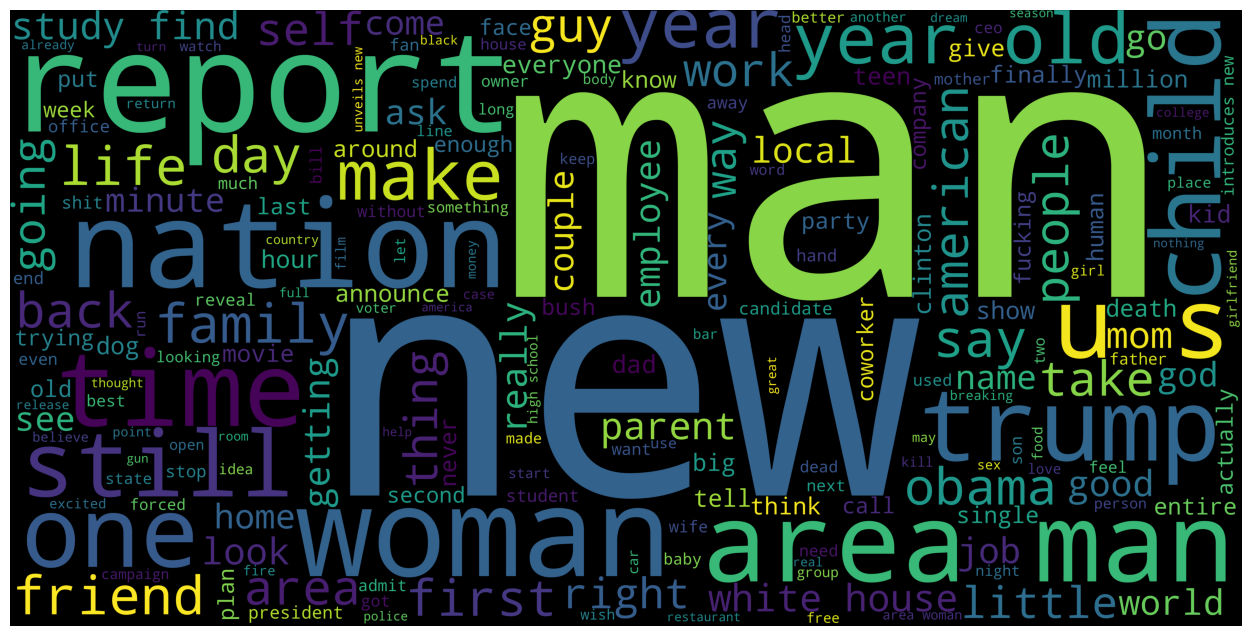

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
sarcastic_list_word = list(itertools.chain(*sarcastic_word_lem))
from wordcloud import WordCloud
sarcastic_cloud = WordCloud(background_color='black', width=10000,height=5000).\
                generate(" ".join(sarcastic_list_word))
plt.imshow(sarcastic_cloud)
plt.axis('off')
plt.show()

### WordCloud of Non Sarcastic Headlines after Lemmatisation

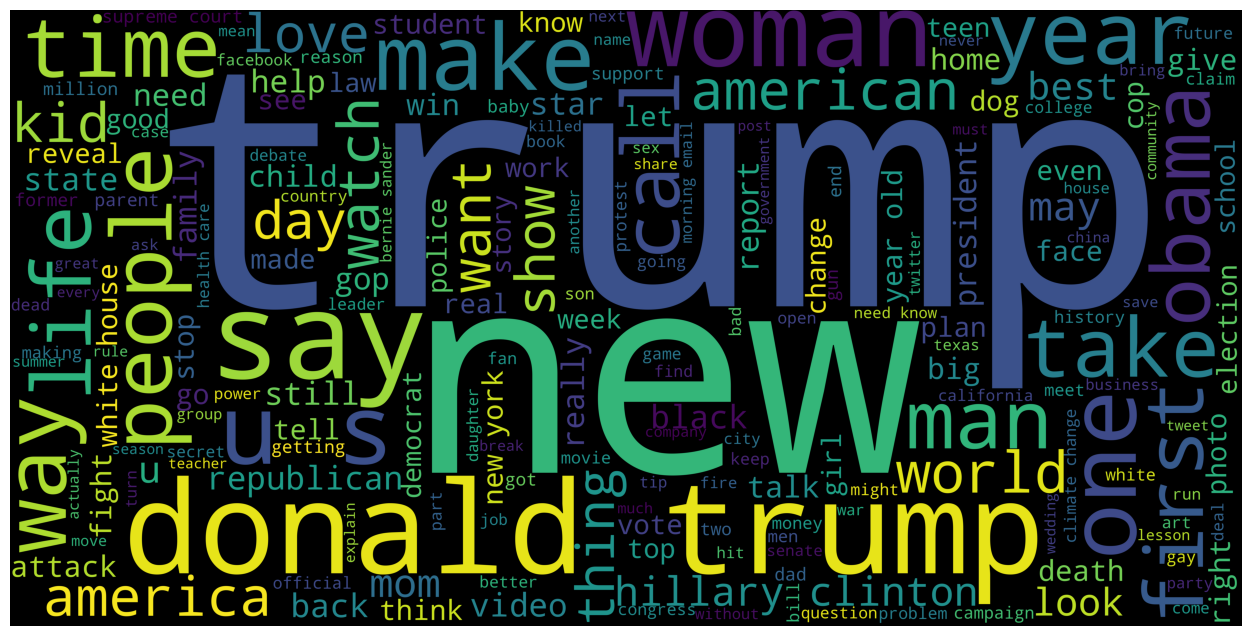

In [25]:
non_sarcastic_list_word = list(itertools.chain(*non_sarcastic_word_lem))
non_sarcastic_cloud = WordCloud(background_color='black', width=10000,height=5000).\
                generate(" ".join(non_sarcastic_list_word))
plt.imshow(non_sarcastic_cloud)
plt.axis('off')
plt.show()

#### DEALING WITH BI-GRAMS

In [26]:
sarcastic_word_lem_df = pd.DataFrame({'sarcasm':sarcastic_word_lem})
non_sarcastic_word_lem_df = pd.DataFrame({'non-sarcasm':non_sarcastic_word_lem})

# custom function for ngram generation
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# custom function for horizontal bar chart
def horizontal_bar_chart(df_sarcasm, color):
    trace = go.Bar(
        y=df_sarcasm["word"].values[::-1],
        x=df_sarcasm["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
     )
    return trace

#Plotting the Bigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sarcastic_word_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sarcasm_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in non_sarcastic_word_lem_df["non-sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
non_sarcasm_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Sarcasm Headlines", 
                                          "Frequent bigrams of Non-Sarcasm Headlines"])
fig.append_trace(sarcasm_2, 1, 1)
fig.append_trace(non_sarcasm_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots Sarcasm Vs Non-Sarcasm after removing Stopwords")
iplot(fig, filename='word-plots')


C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### DEALING WITH TRI-GRAMS

In [27]:
#Plotting the Trigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in sarcastic_word_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sarcasm_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


freq_dict = defaultdict(int)
for sent in non_sarcastic_word_lem_df["non-sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
non_sarcasm_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent Trigrams of Sarcastic Headlines", 
                                          "Frequent Trigrams of Non Sarcastic Headlines"])
fig.append_trace(sarcasm_2, 1, 1)
fig.append_trace(non_sarcasm_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Plots Sarcasm Vs Non-Sarcasm after removing Stopwords")
iplot(fig, filename='word-plots')

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### LDA

In [28]:
import en_core_web_sm
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\711994\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\711994\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
text_data = []
for headline in sarcasm_main.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)

In [32]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

In [33]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.007*"woman" + 0.006*"change" + 0.005*"report" + 0.005*"thing" + 0.005*"getting"'),
 (1,
  '0.012*"clinton" + 0.008*"hillary" + 0.005*"woman" + 0.005*"american" + 0.005*"world"'),
 (2,
  '0.014*"first" + 0.012*"woman" + 0.009*"study" + 0.008*"find" + 0.008*"report"'),
 (3,
  '0.053*"trump" + 0.014*"donald" + 0.012*"house" + 0.011*"white" + 0.009*"obama"'),
 (4,
  '0.008*"woman" + 0.007*"world" + 0.005*"release" + 0.004*"celebrate" + 0.004*"dream"')]

In [34]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.036*"trump" + 0.010*"woman" + 0.009*"donald" + 0.007*"world" + 0.006*"clinton"'),
 (1,
  '0.008*"house" + 0.007*"still" + 0.007*"white" + 0.006*"report" + 0.006*"study"'),
 (2,
  '0.009*"woman" + 0.006*"right" + 0.006*"change" + 0.006*"report" + 0.005*"really"')]

In [35]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.015*"student" + 0.013*"college" + 0.011*"health" + 0.011*"season" + 0.010*"teacher"'),
 (1,
  '0.038*"american" + 0.020*"study" + 0.020*"report" + 0.018*"find" + 0.012*"police"'),
 (2,
  '0.022*"clinton" + 0.014*"hillary" + 0.013*"republican" + 0.011*"movie" + 0.010*"things"'),
 (3,
  '0.021*"change" + 0.014*"school" + 0.014*"court" + 0.011*"woman" + 0.011*"finally"'),
 (4,
  '0.017*"world" + 0.012*"break" + 0.009*"woman" + 0.008*"start" + 0.008*"miss"'),
 (5,
  '0.015*"watch" + 0.012*"claim" + 0.010*"making" + 0.009*"unveil" + 0.009*"story"'),
 (6,
  '0.032*"house" + 0.030*"white" + 0.011*"obama" + 0.010*"introduce" + 0.009*"middle"'),
 (7,
  '0.014*"release" + 0.010*"employee" + 0.009*"reason" + 0.009*"record" + 0.008*"night"'),
 (8,
  '0.115*"trump" + 0.030*"donald" + 0.022*"state" + 0.013*"president" + 0.008*"money"'),
 (9,
  '0.016*"parent" + 0.015*"every" + 0.014*"woman" + 0.013*"getting" + 0.012*"think"')]

In [36]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [37]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [38]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [39]:
from numpy import mean

sarcastic = list(sarcasm_main.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(sarcasm_main.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])



For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.06985669), (1, 0.012501072), (2, 0.12722789), (3, 0.2991683), (4, 0.012501158), (5, 0.13754551), (6, 0.24678832), (7, 0.012500925), (8, 0.0694091), (9, 0.012501037)]

For Non-sarcastic Dataset:
[(0, 0.08029085), (1, 0.012503604), (2, 0.14809643), (3, 0.29353547), (4, 0.012503676), (5, 0.13756417), (6, 0.2107369), (7, 0.012503477), (8, 0.079761855), (9, 0.012503574)]


In [40]:
sarcastic = list(sarcasm_main.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 5 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(sarcasm_main.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])



For LDA model with 5 clusters:
For Sarcastic Dataset:
[(0, 0.02391748), (1, 0.5816389), (2, 0.21082836), (3, 0.15994047), (4, 0.023674836)]

For Non-sarcastic Dataset:
[(0, 0.024147514), (1, 0.5659889), (2, 0.20099826), (3, 0.18494746), (4, 0.023917843)]


In [41]:
sarcastic = list(sarcasm_main.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda3[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 3 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(sarcasm_main.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda3[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])



For LDA model with 3 clusters:
For Sarcastic Dataset:
[(0, 0.52061653), (1, 0.043724116), (2, 0.43565938)]

For Non-sarcastic Dataset:
[(0, 0.5322934), (1, 0.044532347), (2, 0.42317426)]


## SECOND PHASE SARCASM PREDICTION USING DEEP LEARNING METHODS

In [42]:
data1 = pd.read_json("G:\\SECOND SEMESTER\\I CAN PLUS TO GOD BE ALL GLORY\\APPLIED ARTFICIAL INTELLIGENCE\\GRADED FOLDER\\SARCASM DETECTION IN SENTIMENT ANALYSIS\\Sarcasm_Headlines_Dataset.json\\Sarcasm_Headlines_Dataset.json", lines=True)
data2 = pd.read_json("G:\SECOND SEMESTER\I CAN PLUS TO GOD BE ALL GLORY\APPLIED ARTFICIAL INTELLIGENCE\GRADED FOLDER\SARCASM DETECTION IN SENTIMENT ANALYSIS\Sarcasm_Headlines_Dataset_v2.json\Sarcasm_Headlines_Dataset_v2.json", lines=True)

data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

<>:2: DeprecationWarning:

invalid escape sequence '\S'

<>:2: DeprecationWarning:

invalid escape sequence '\S'

C:\Users\711994\AppData\Local\Temp\ipykernel_3848\3734335706.py:2: DeprecationWarning:

invalid escape sequence '\S'



In [43]:
data

headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
...                                                  ...           ...
55323       jews to celebrate rosh hashasha or something             1
55324  internal affairs investigator disappointed con...             1
55325  the most beautiful acceptance speech this week...             0
55326  mars probe destroyed by orbiting spielberg-gat...             1
55327                 dad clarifies this not a food stop             1

[55328 rows x 2 columns]

In [44]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

<>:7: DeprecationWarning:

invalid escape sequence '\s'

<>:7: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\711994\AppData\Local\Temp\ipykernel_3848\950512278.py:7: DeprecationWarning:

invalid escape sequence '\s'



In [45]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\711994\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|███████████████████████████████████████████████████████████████████████████| 55328/55328 [03:35<00:00, 257.07it/s]


In [47]:
data['clean_headline'] = data['headline'].apply(text_cleaning)

In [48]:
import en_core_web_sm
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [49]:
sentences = data['clean_headline']
label = data['is_sarcastic']

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentences, label, train_size = 0.8, random_state = 42, shuffle = True)

In [51]:
#tokenize text
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

### GLOVE EMBEDDING 

In [52]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [53]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
1384/1384 - 2s - loss: 0.6233 - accuracy: 0.6441 - val_loss: 0.4692 - val_accuracy: 0.7919 - 2s/epoch - 2ms/step
Epoch 2/30
1384/1384 - 2s - loss: 0.3869 - accuracy: 0.8309 - val_loss: 0.3768 - val_accuracy: 0.8307 - 2s/epoch - 1ms/step
Epoch 3/30
1384/1384 - 2s - loss: 0.3106 - accuracy: 0.8674 - val_loss: 0.3694 - val_accuracy: 0.8369 - 2s/epoch - 1ms/step
Epoch 4/30
1384/1384 - 2s - loss: 0.2709 - accuracy: 0.8862 - val_loss: 0.3372 - val_accuracy: 0.8520 - 2s/epoch - 1ms/step
Epoch 5/30
1384/1384 - 2s - loss: 0.2460 - accuracy: 0.8994 - val_loss: 0.3315 - val_accuracy: 0.8577 - 2s/epoch - 1ms/step
Epoch 6/30
1384/1384 - 2s - loss: 0.2255 - accuracy: 0.9086 - val_loss: 0.3284 - val_accuracy: 0.8621 - 2s/epoch - 1ms/step
Epoch 7/30
1384/1384 - 2s - loss: 0.2111 - accuracy: 0.9160 - val_loss: 0.3290 - val_accuracy: 0.8649 - 2s/epoch - 1ms/step
Epoch 8/30
1384/1384 - 2s - loss: 0.1983 - accuracy: 0.9226 - val_loss: 0.3259 - val_accuracy: 0.8705 - 2s/epoch - 1ms/step
Epoch 9/

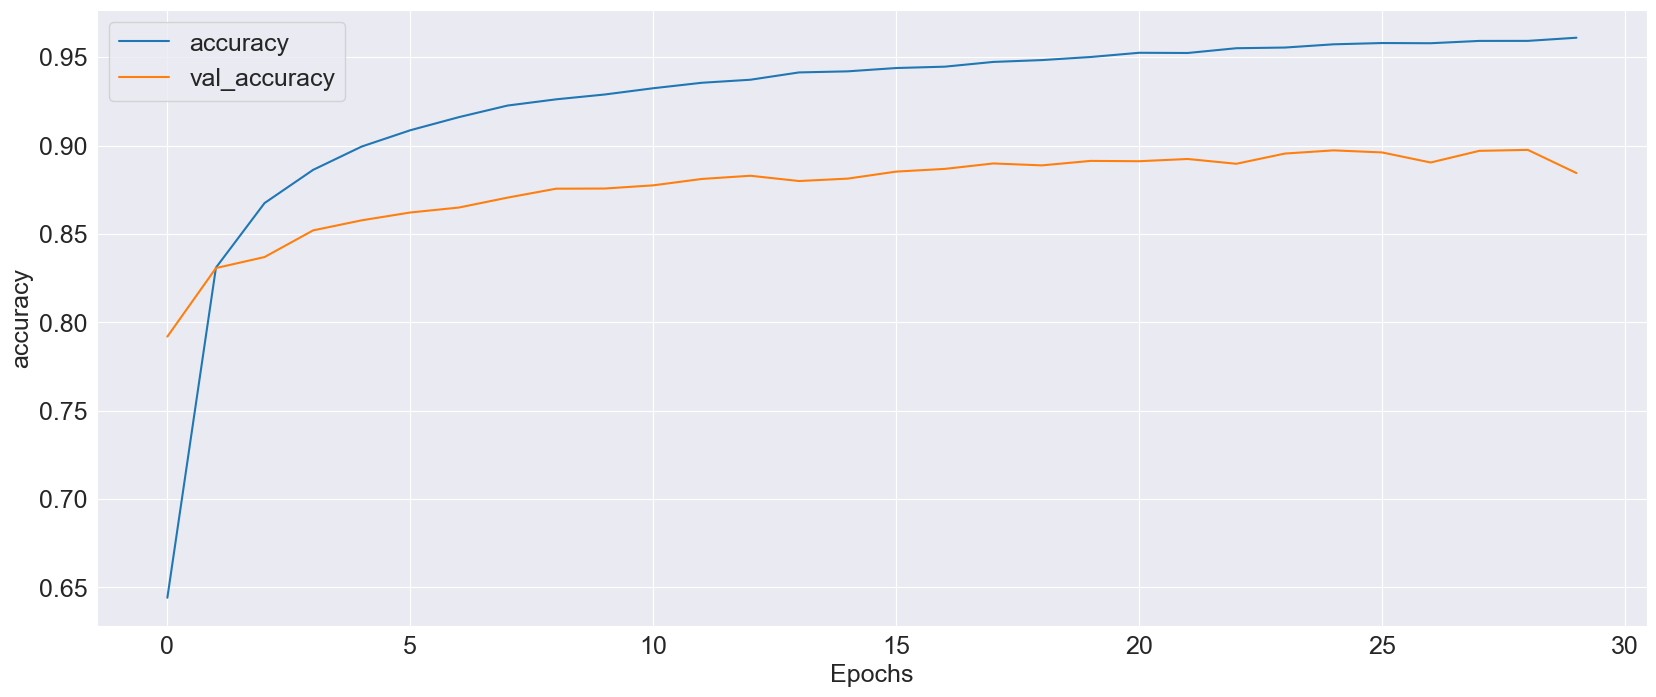

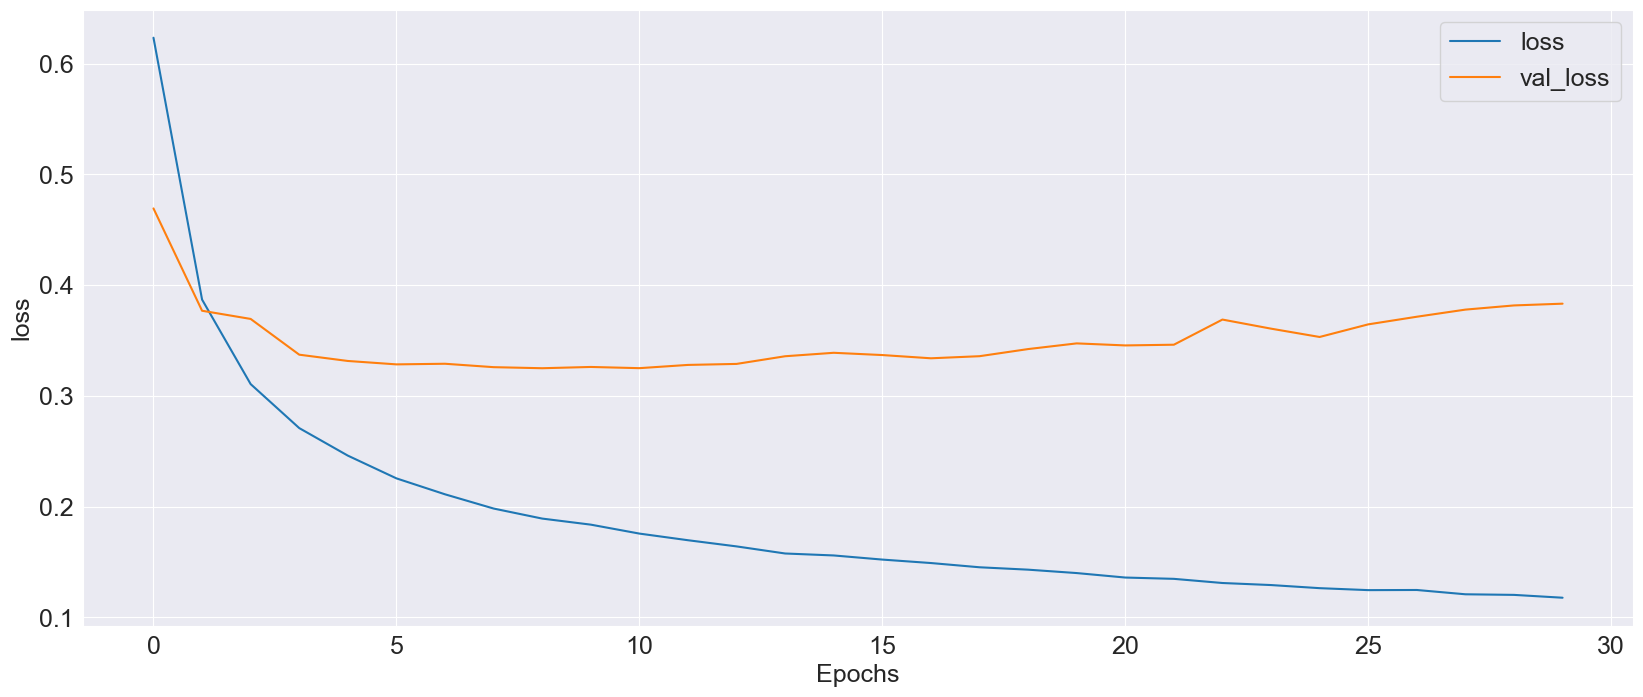

In [54]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

346/346 [==============================] - 0s 549us/step


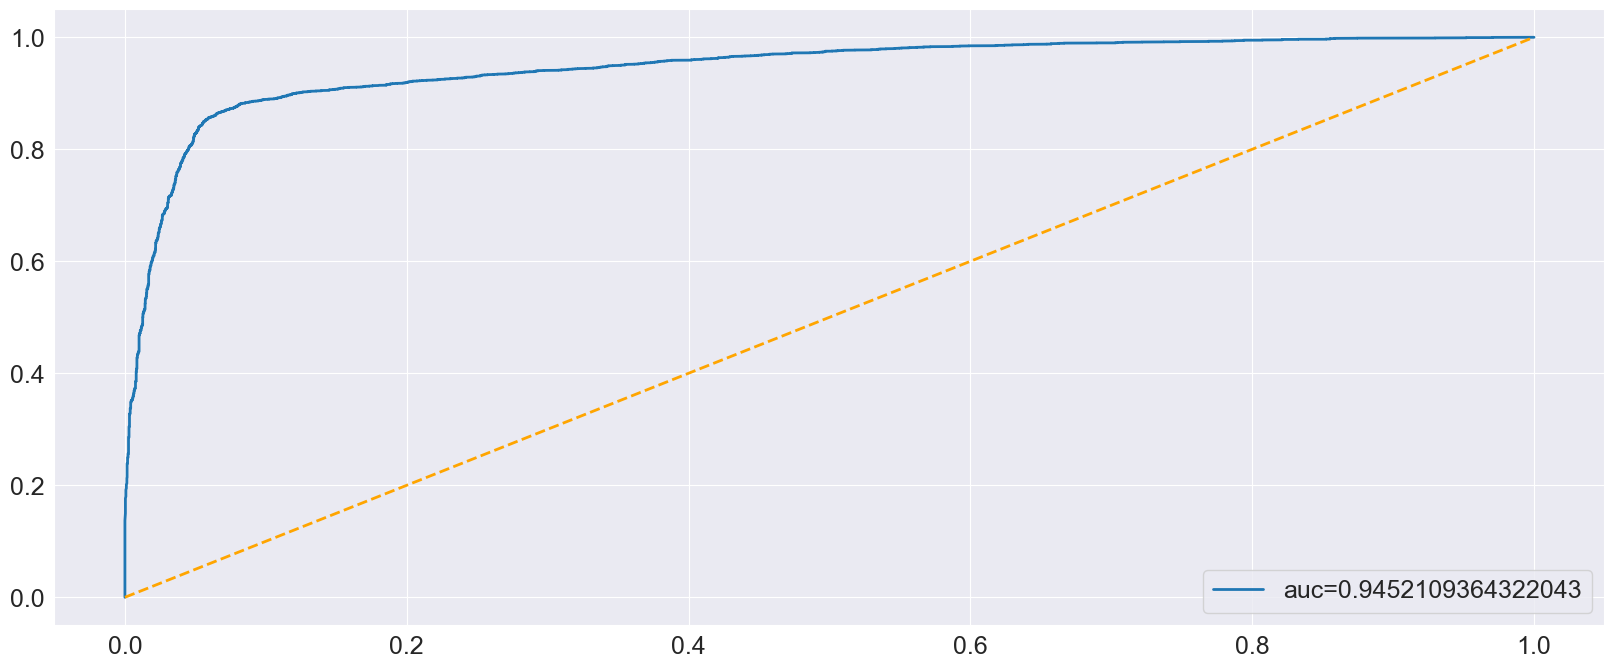

In [55]:
#testing_padded, testing_labels
y_pred = model.predict(testing_padded)
fpr, tpr, _ = roc_curve(testing_labels,  y_pred)
auc = roc_auc_score(testing_labels, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [56]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      5878
           1       0.95      0.71      0.81      5188

    accuracy                           0.85     11066
   macro avg       0.87      0.84      0.84     11066
weighted avg       0.87      0.85      0.84     11066



<Axes: >

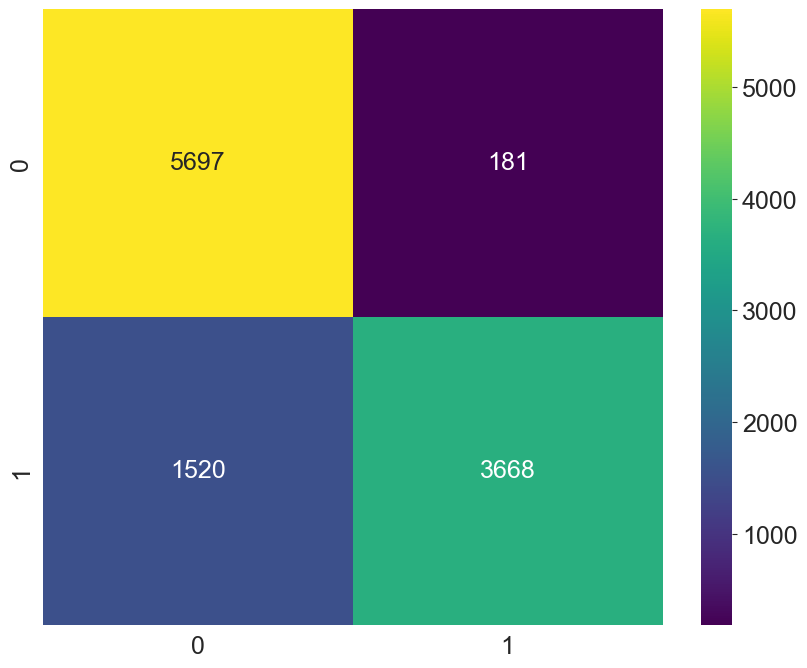

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')

### BiRNN (GRU) with L2 Ridge Regularization / Dropout / Batch Normalization

In [58]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [59]:
num_epochs = 20
history_gru = model_gru.fit(training_padded, training_labels, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels))

Epoch 1/20
692/692 [==============================] - 20s 25ms/step - loss: 0.4619 - accuracy: 0.8042 - val_loss: 0.7697 - val_accuracy: 0.6387
Epoch 2/20
692/692 [==============================] - 17s 24ms/step - loss: 0.2377 - accuracy: 0.9099 - val_loss: 0.2841 - val_accuracy: 0.8906
Epoch 3/20
692/692 [==============================] - 17s 24ms/step - loss: 0.1614 - accuracy: 0.9427 - val_loss: 0.2971 - val_accuracy: 0.8956
Epoch 4/20
692/692 [==============================] - 18s 26ms/step - loss: 0.1084 - accuracy: 0.9645 - val_loss: 0.2495 - val_accuracy: 0.9286
Epoch 5/20
692/692 [==============================] - 19s 27ms/step - loss: 0.0747 - accuracy: 0.9763 - val_loss: 0.4888 - val_accuracy: 0.8387
Epoch 6/20
692/692 [==============================] - 17s 24ms/step - loss: 0.0561 - accuracy: 0.9825 - val_loss: 0.2508 - val_accuracy: 0.9394
Epoch 7/20
692/692 [==============================] - 16s 24ms/step - loss: 0.0452 - accuracy: 0.9872 - val_loss: 0.2864 - val_accuracy:

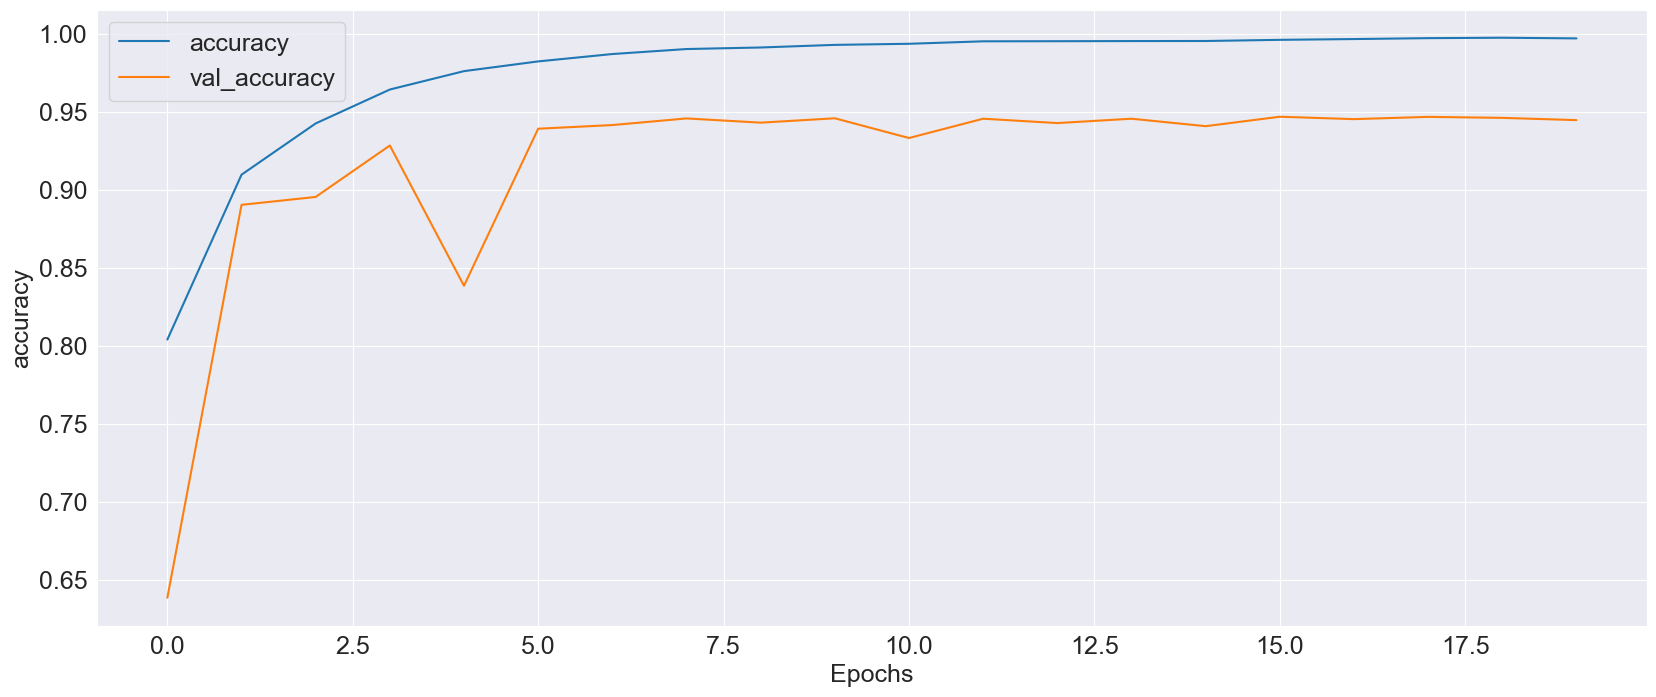

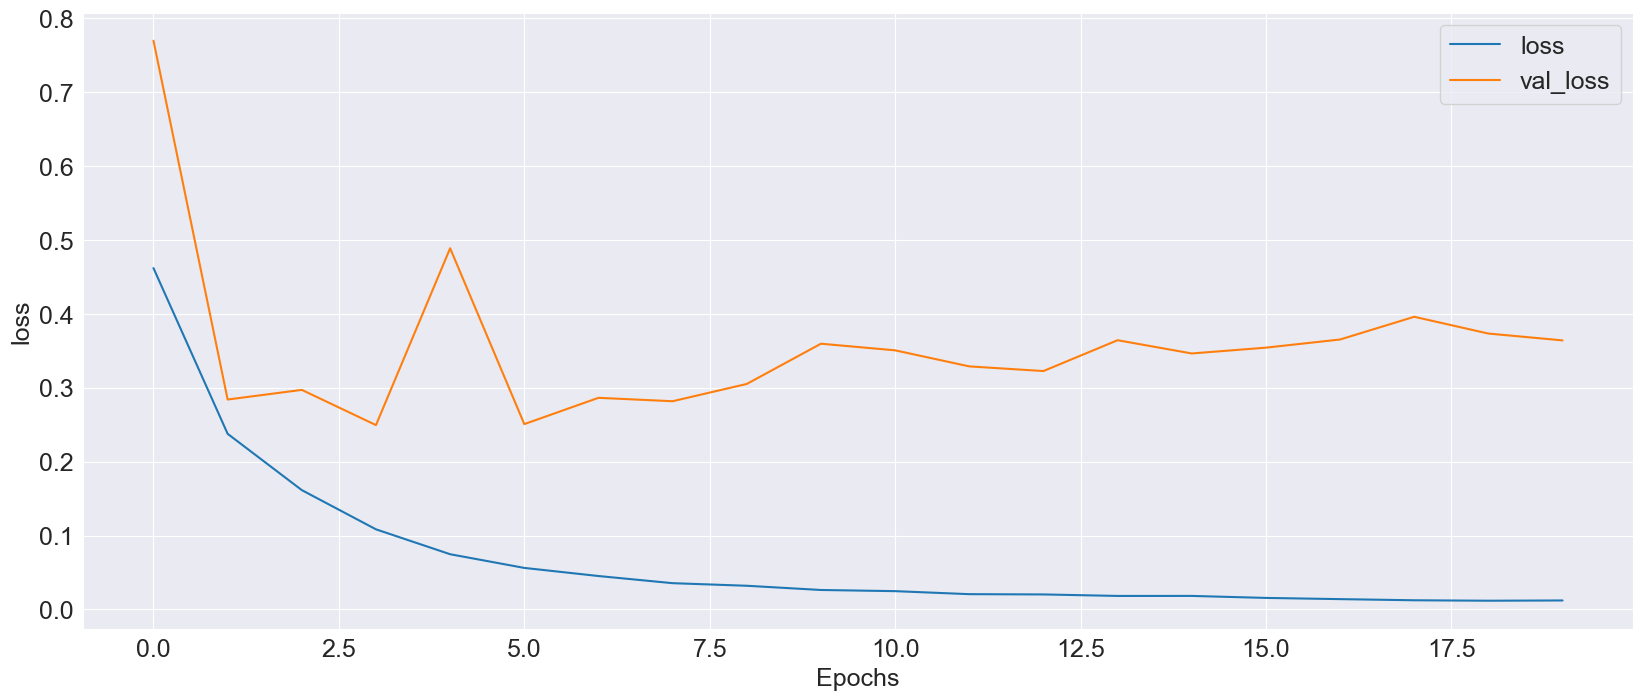

In [60]:
def plot_graphs(history_gru, string):
    plt.plot(history_gru.history[string])
    plt.plot(history_gru.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')
plt.show()

346/346 [==============================] - 2s 4ms/step


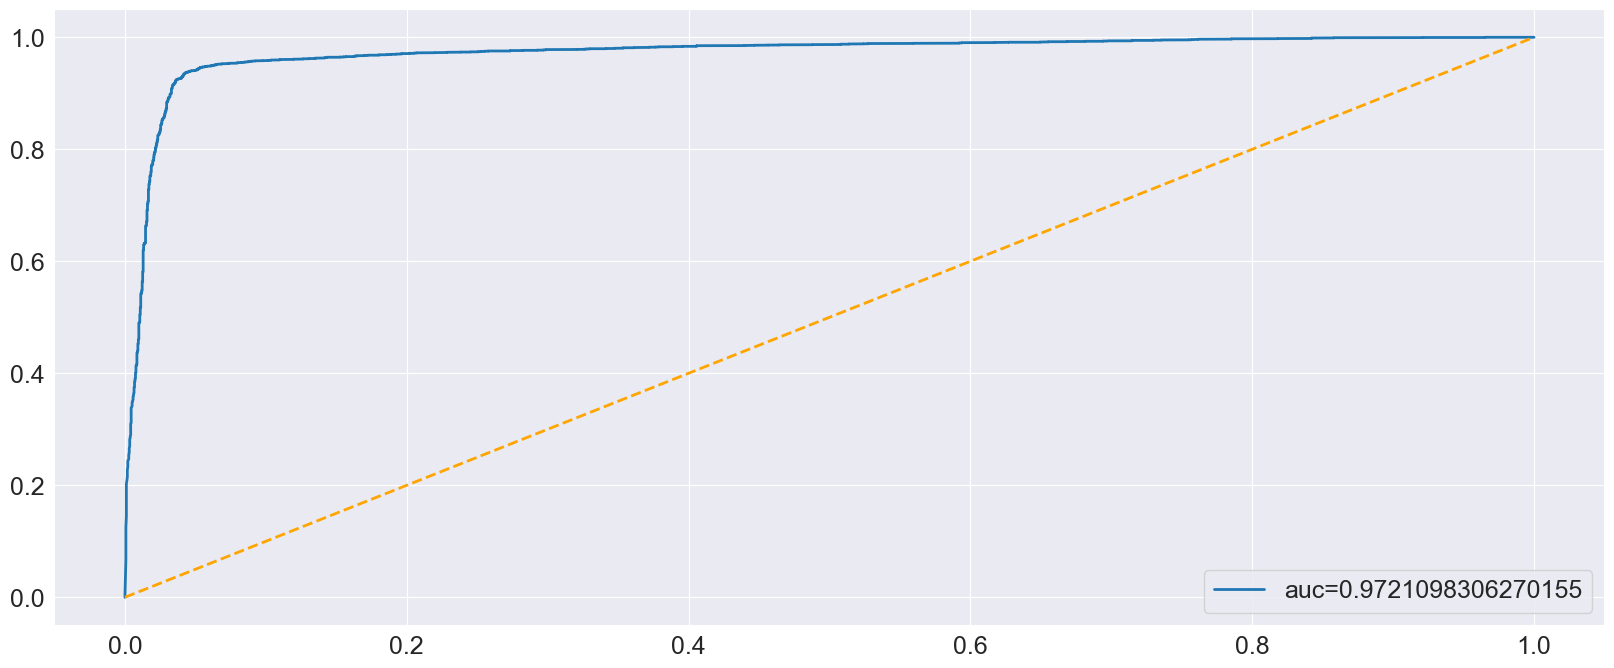

In [61]:
y_pred = model_gru.predict(testing_padded)
fpr, tpr, _ = roc_curve(testing_labels,  y_pred)
auc = roc_auc_score(testing_labels, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [62]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5878
           1       0.96      0.91      0.94      5188

    accuracy                           0.94     11066
   macro avg       0.94      0.94      0.94     11066
weighted avg       0.94      0.94      0.94     11066



<Axes: >

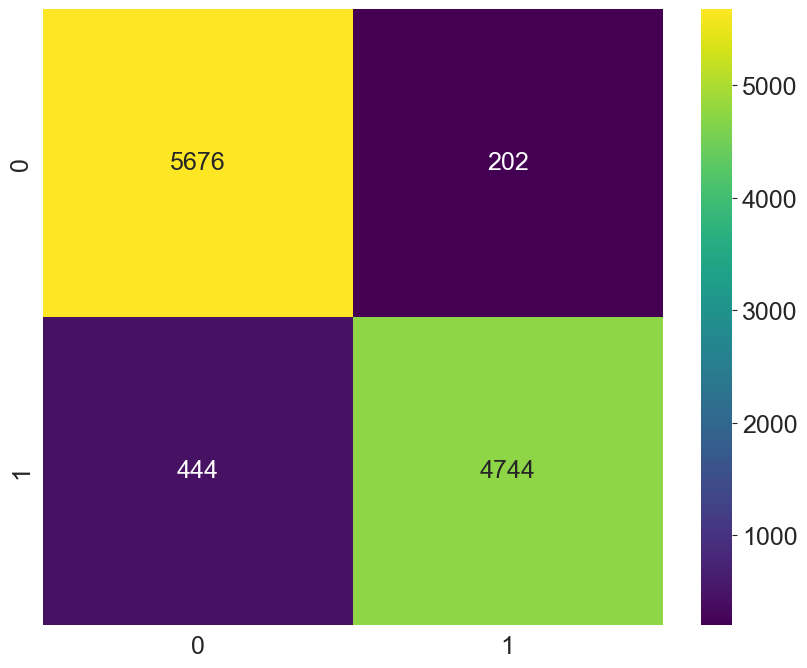

In [63]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')

### BERT MODEL

In [64]:
#Train - Validation - Test Splitting (80:10:10)

X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [65]:
#Tokenization
#Splitting sentences into words Finding the vocab size
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20900


In [66]:
#Encoding of Inputs
#Converting the sentences to token followed by padded sequences in encoded format These are numeric encodings assigned to each word

train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [67]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.3)
        self.dropout2 = layers.Dropout(0.3)  #reduce from 0.5

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [68]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 30000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model3= Model(inputs=inputs, outputs=outputs)

In [69]:
model3.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           1501000   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 20, 50)           23832     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 50)                0     

In [70]:
#model training
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000002)



In [71]:
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

In [72]:
history3 = model3.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
1384/1384 [==============================] - 40s 28ms/step - loss: 0.4691 - accuracy: 0.7624 - val_loss: 0.3312 - val_accuracy: 0.8556
Epoch 2/25
1384/1384 [==============================] - 37s 27ms/step - loss: 0.2503 - accuracy: 0.9015 - val_loss: 0.2680 - val_accuracy: 0.8905
Epoch 3/25
1384/1384 [==============================] - 36s 26ms/step - loss: 0.1723 - accuracy: 0.9352 - val_loss: 0.2340 - val_accuracy: 0.9160
Epoch 4/25
1384/1384 [==============================] - 37s 27ms/step - loss: 0.1203 - accuracy: 0.9583 - val_loss: 0.2252 - val_accuracy: 0.9297
Epoch 5/25
1384/1384 [==============================] - 37s 27ms/step - loss: 0.0825 - accuracy: 0.9728 - val_loss: 0.2145 - val_accuracy: 0.9398
Epoch 6/25
1384/1384 [==============================] - 37s 27ms/step - loss: 0.0573 - accuracy: 0.9819 - val_loss: 0.2351 - val_accuracy: 0.9431
Epoch 6: early stopping


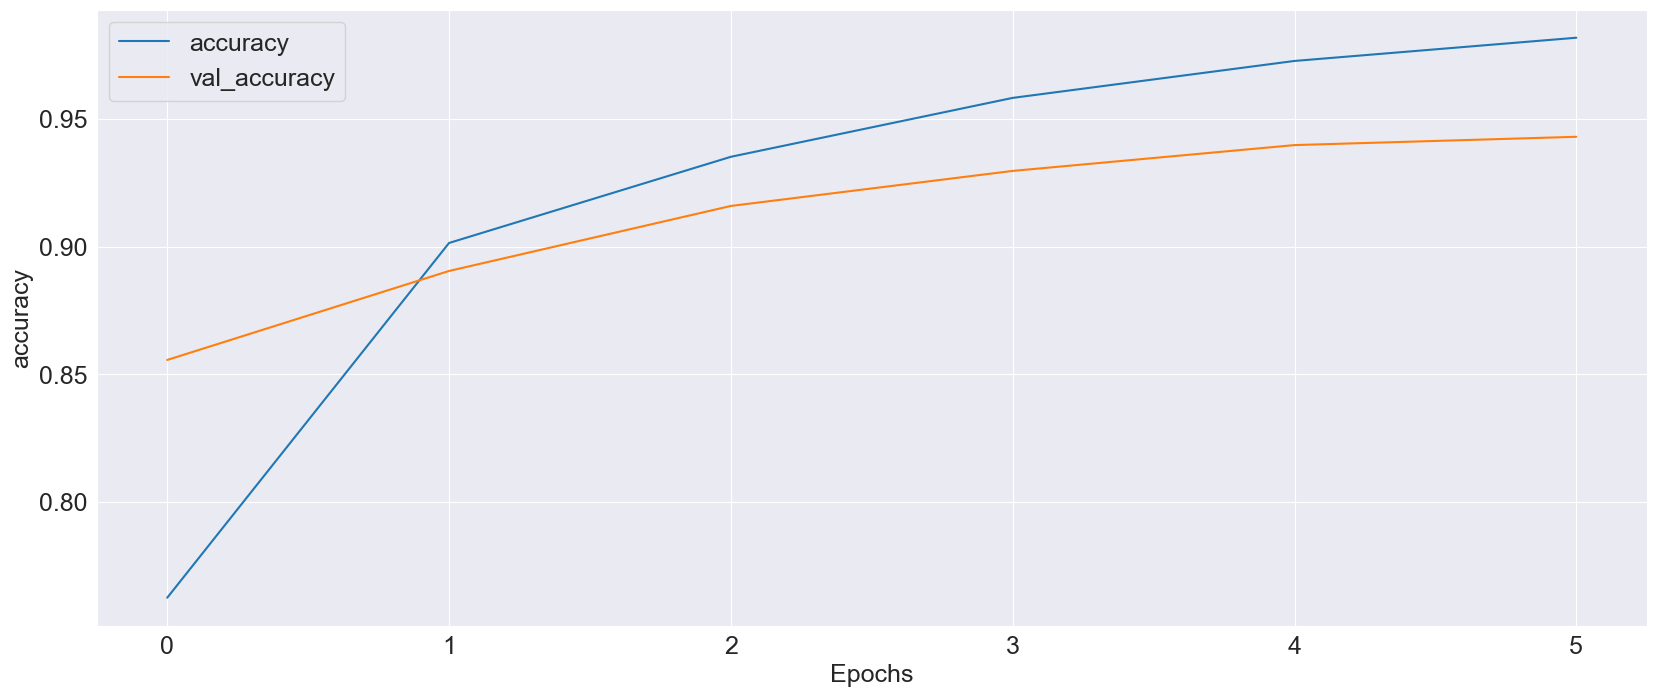

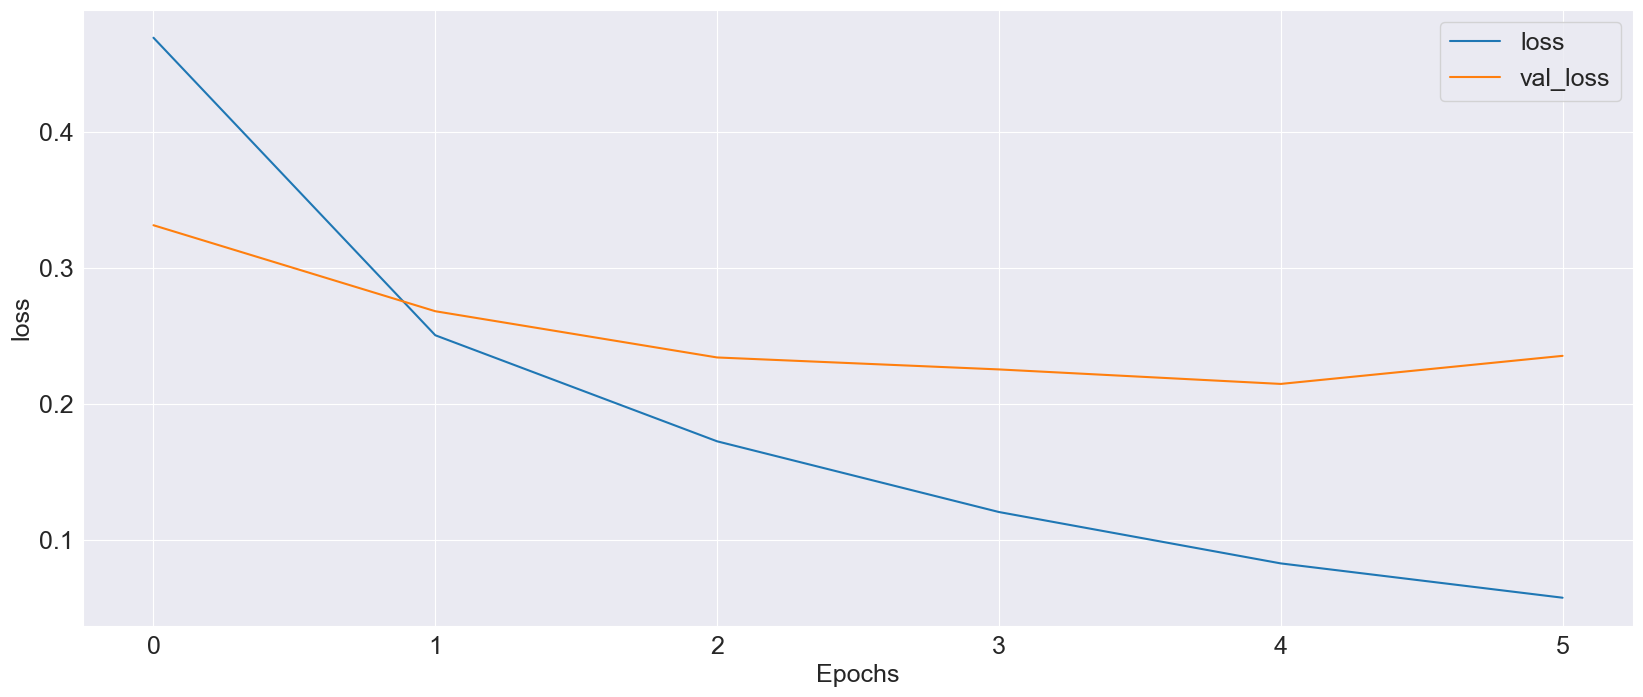

In [73]:
def plot_graphs(history3, string):
    plt.plot(history3.history[string])
    plt.plot(history3.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')
plt.show()

173/173 [==============================] - 1s 2ms/step


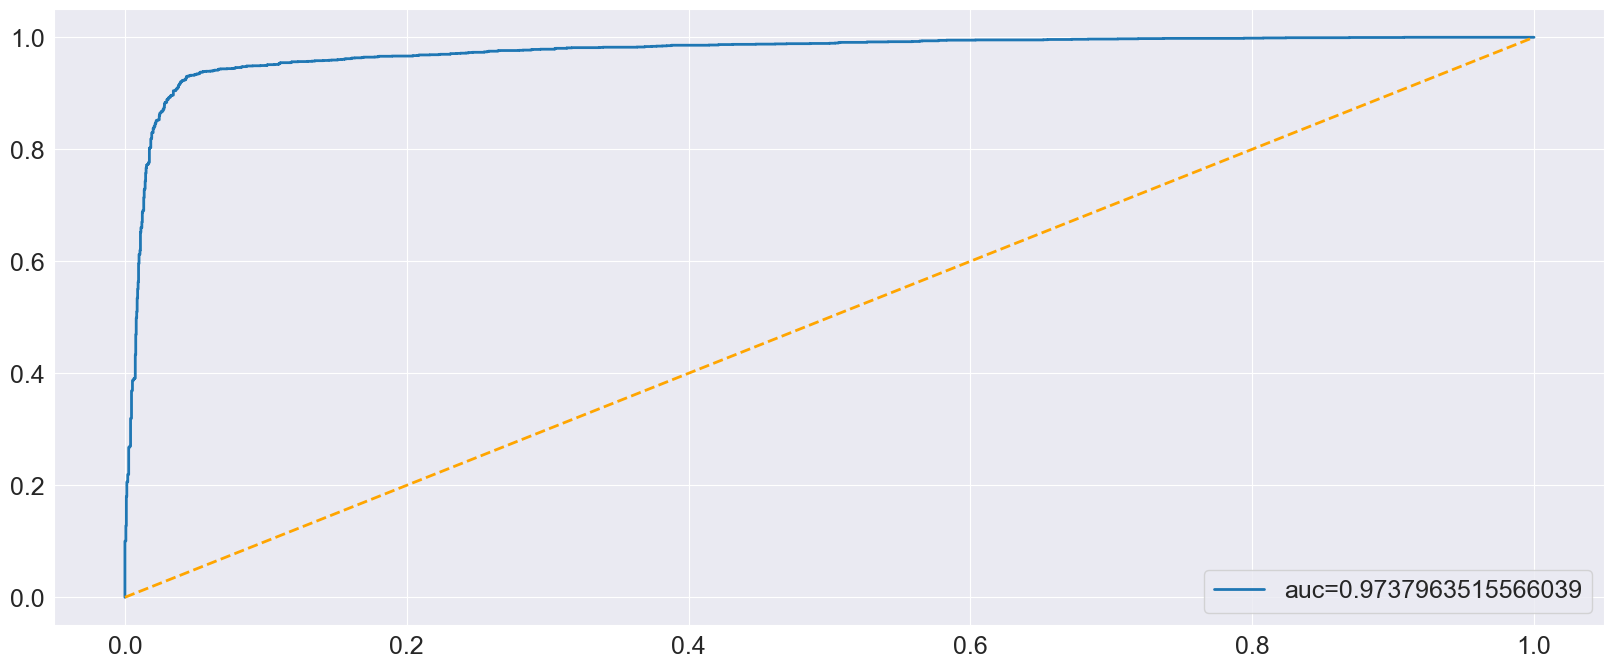

In [74]:
y_pred = model3.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [75]:
#Scores: Test Set Result
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2997
           1       0.95      0.91      0.93      2536

    accuracy                           0.94      5533
   macro avg       0.94      0.94      0.94      5533
weighted avg       0.94      0.94      0.94      5533



<Axes: >

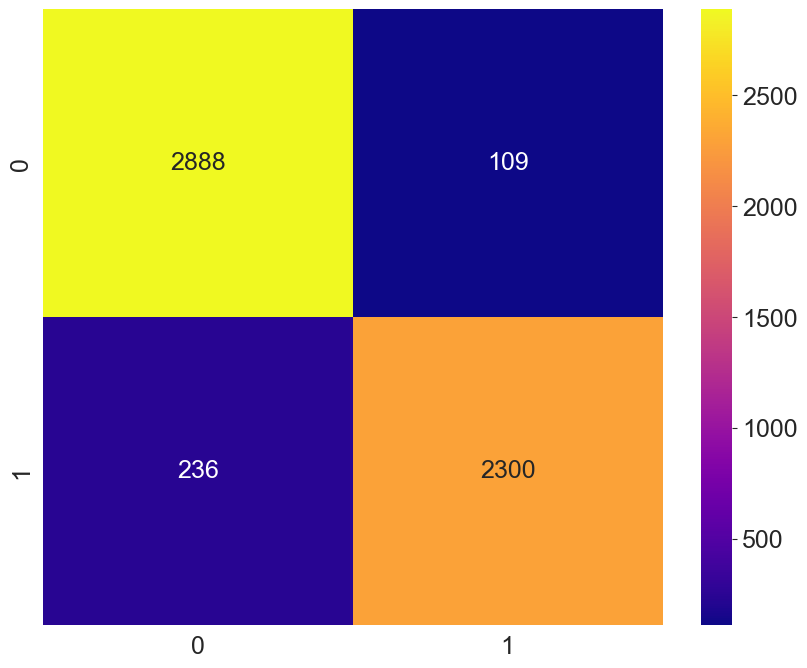

In [76]:
#CONFUSION MATRIX

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='plasma')

### BERT2

In [77]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 30000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.15)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model4= Model(inputs=inputs, outputs=outputs)

In [78]:
model4.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           1501000   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_1 (Tran  (None, 20, 50)           23832     
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 50)                0   

In [79]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000002)


In [80]:
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

In [81]:
history4 = model4.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=5,
                    batch_size=32,callbacks=[earlystopping])

Epoch 1/5
1384/1384 [==============================] - 38s 26ms/step - loss: 0.4577 - accuracy: 0.7734 - val_loss: 0.3474 - val_accuracy: 0.8473
Epoch 2/5
1384/1384 [==============================] - 36s 26ms/step - loss: 0.2413 - accuracy: 0.9038 - val_loss: 0.2609 - val_accuracy: 0.8961
Epoch 3/5
1384/1384 [==============================] - 39s 28ms/step - loss: 0.1629 - accuracy: 0.9399 - val_loss: 0.2365 - val_accuracy: 0.9131
Epoch 4/5
1384/1384 [==============================] - 38s 27ms/step - loss: 0.1131 - accuracy: 0.9605 - val_loss: 0.2207 - val_accuracy: 0.9295
Epoch 5/5
1384/1384 [==============================] - 38s 27ms/step - loss: 0.0766 - accuracy: 0.9740 - val_loss: 0.2081 - val_accuracy: 0.9405


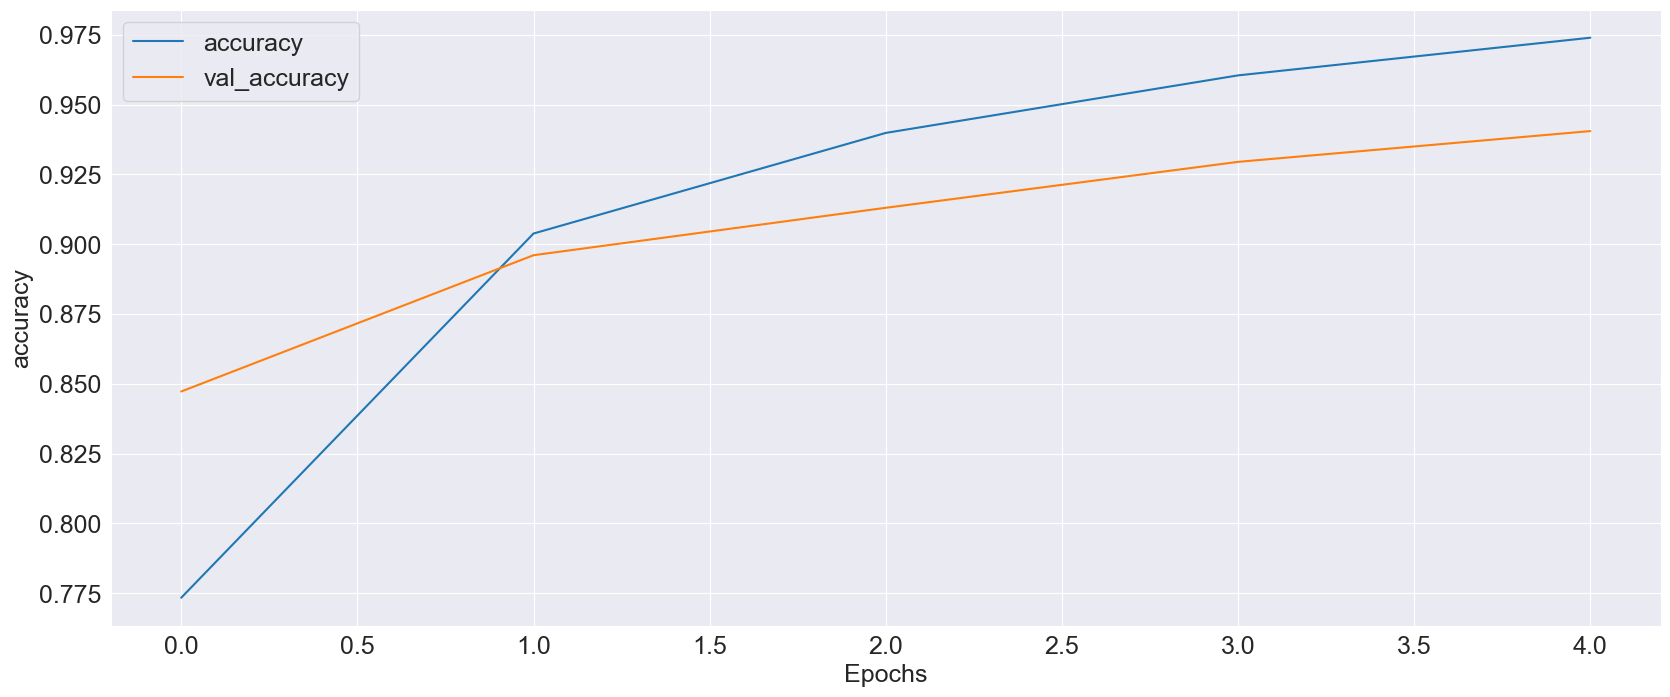

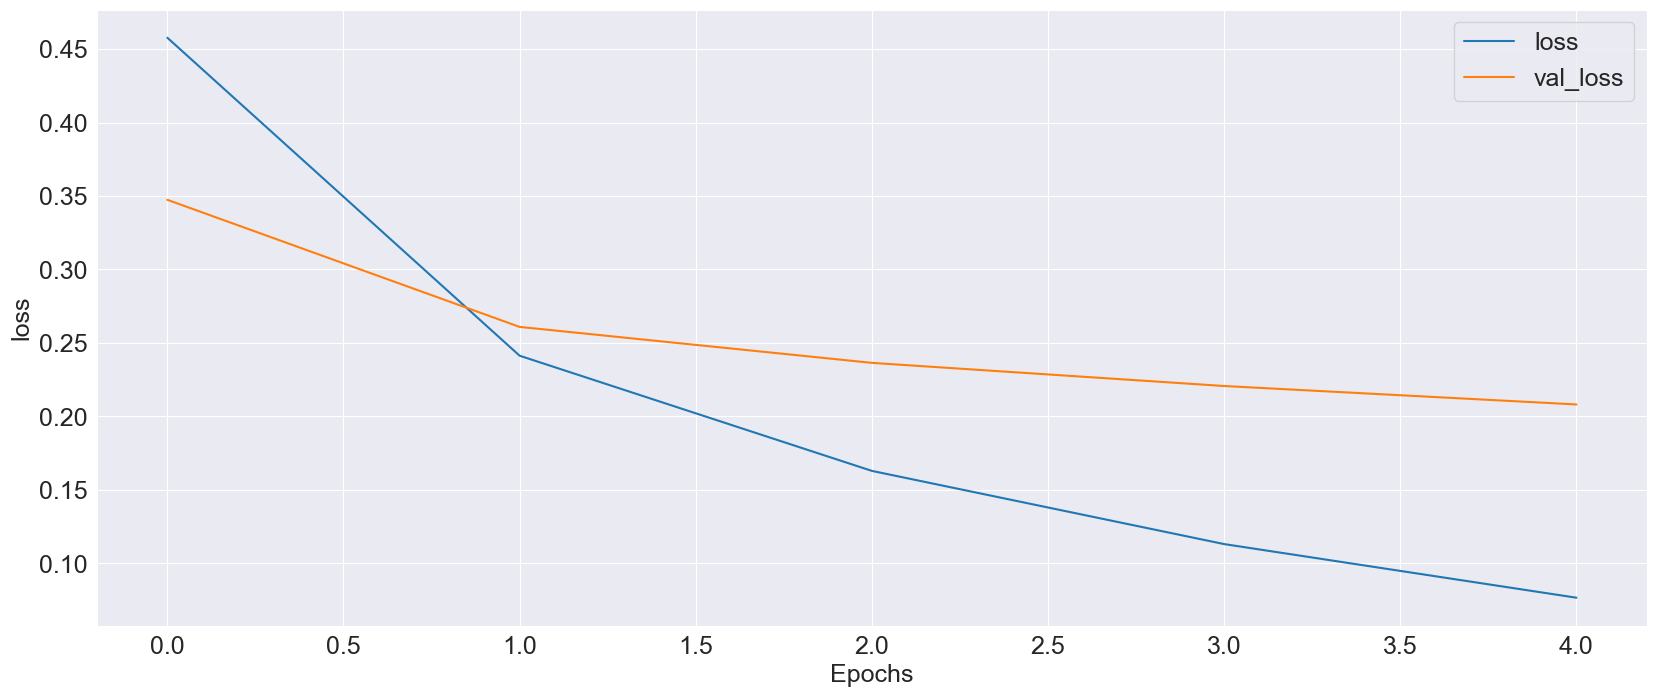

In [82]:
def plot_graphs(history4, string):
    plt.plot(history4.history[string])
    plt.plot(history4.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')
plt.show()

173/173 [==============================] - 0s 2ms/step


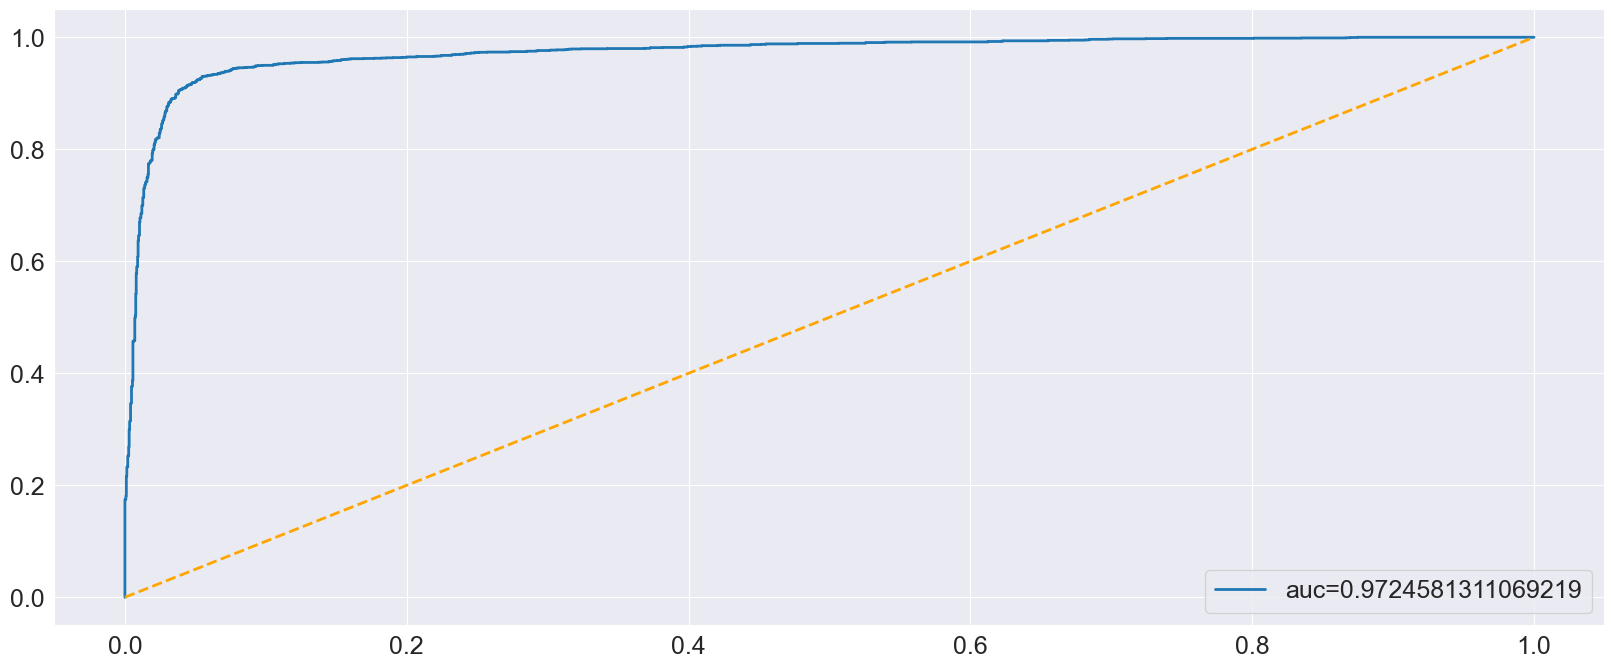

In [83]:
y_pred = model4.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [84]:
from pandas import DataFrame
accuracy = [max(history.history['val_accuracy']),max(history_gru.history['val_accuracy']),max(history3.history['val_accuracy']),max(history4.history['val_accuracy'])]
loss = [max(history.history['val_loss']),max(history_gru.history['val_loss']),max(history3.history['val_loss']),max(history4.history['val_loss'])]

col={'Accuracy':accuracy,'Loss':loss}
models=['GloveEmbed','BiRNN(GRU)','BERT','BERT2']
graph_df=DataFrame(data=col,index=models)
graph_df

Accuracy      Loss
GloveEmbed  0.897524  0.469188
BiRNN(GRU)  0.947045  0.769742
BERT        0.943069  0.331191
BERT2       0.940539  0.347400

<Axes: >

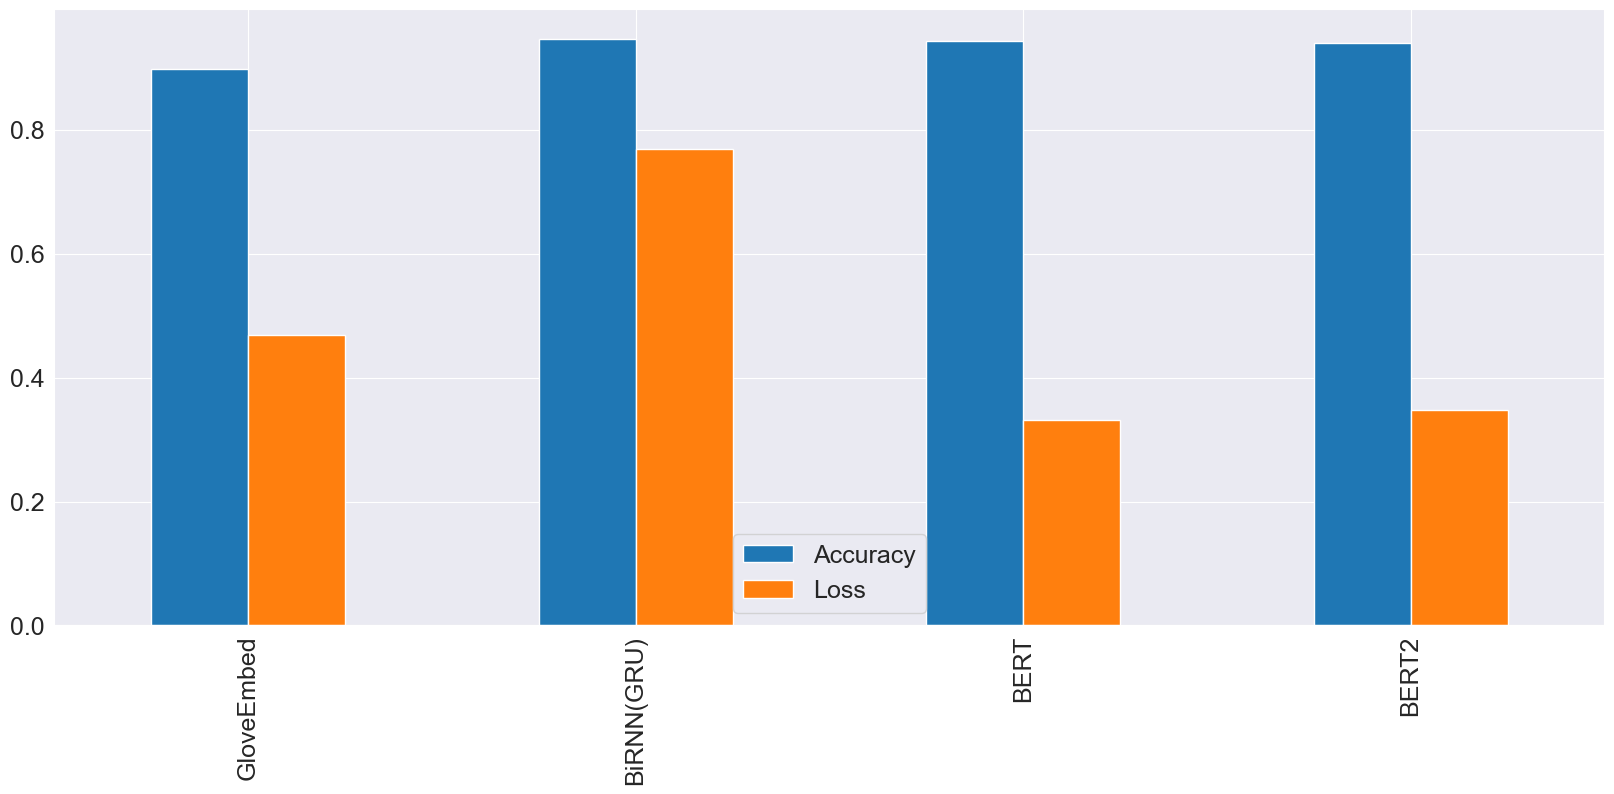

In [85]:
graph_df.plot(kind='bar')